#### Post viralness (views) drivers

In [2]:
# Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re
import spacy
import emoji

In [3]:
# Import data
df = pd.read_csv("../data/filtered_data/comments_posts_transcripts.csv", encoding='utf-8')

df['createTimeISO'] = (
    pd.to_datetime(df['createTimeISO'], utc=True, errors='coerce')
      .dt.tz_convert('Europe/Berlin')
)

nine_months = pd.Timestamp.utcnow() - pd.DateOffset(months=9)
df = df[df['createTimeISO'] >= nine_months]

### Preprocessing


In [4]:
df = df[df['textLanguage'] == 'en']

In [5]:
def combine_text(row, include_description=True):
    # Start with caption
    texts = []
    if pd.notna(row['text']):
        texts.append(str(row['text']))
    if pd.notna(row['transcribed_text']):
        texts.append(str(row['transcribed_text']))
    if include_description and pd.notna(row['video_description']):
        texts.append(str(row['video_description']))
    return ' '.join(texts)


In [6]:
# Create the concatenated text column FIRST
text_cols = ['text', 'video_description', 'transcribed_text']
df['text_all'] = df[text_cols].fillna('').agg(' '.join, axis=1)

In [7]:
# All three fields
#df['processed_text'] = df.apply(lambda row: combine_text(row, include_description=True), axis=1)

# Or, only caption + transcript
df['combined_text'] = df.apply(lambda row: combine_text(row, include_description=False), axis=1)

In [8]:
nlp = spacy.load("en_core_web_sm")  # English small model

def clean_text(text, stopwords=None, lemmatize=False):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+", " ", text)
    text = emoji.replace_emoji(text, replace=lambda e, _: f" {e} ")
    text = re.sub(r"[^a-zA-ZäöüÄÖÜß0-9\s#?!\U0001F600-\U0001F64F]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    # Use spaCy tokenizer for more robust tokenization
    tokens = [token.text for token in nlp(text)]
    tokens = [re.sub(r"(.)\1{2,}", r"\1\1", t) for t in tokens]

    if stopwords:
        tokens = [t for t in tokens if t not in stopwords and len(t) > 2]
    else:
        tokens = [t for t in tokens if len(t) > 2]

    if lemmatize and tokens:
        doc = nlp(" ".join(tokens))
        tokens = [token.lemma_ for token in doc]

    return " ".join(tokens)


In [9]:
import os
os.environ["NLTK_DATA"] = "/Users/hannahschlaucher/nltk_data"

In [10]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize


nltk.data.path.append('/Users/hannahschlaucher/nltk_data')
nltk.data.path.append('/Users/hannahschlaucher/nltk_data')
nltk.data.path.append('/Users/hannahschlaucher/nltk_data')




def pos_enhanced_preprocessing(text):
    meaningful_pos = {'NN', 'NNS', 'NNP', 'NNPS',
                      'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',
                      'JJ', 'JJR', 'JJS',
                      'RB', 'RBR', 'RBS'}
    tokens = word_tokenize(text.lower())
    pos_tags = pos_tag(tokens)
    meaningful_tokens = [token for token, pos in pos_tags if pos in meaningful_pos]
    return ' '.join(meaningful_tokens)

#df['combined_text_processed'] = df['combined_text_processed'].apply(pos_enhanced_preprocessing)


In [11]:
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = STOP_WORDS

df['combined_text_processed'] = df['combined_text'].apply(lambda x: clean_text(x, stopwords=stopwords, lemmatize=True))

In [12]:
df.to_csv("processed_combined_text.csv", index=False)

### Feature engineering

In [13]:
# Get time based categories

# Hour of posting (0–23)
df['hour_posting'] = df['createTimeISO'].dt.hour

# Day of week (0=Monday, …, 6=Sunday)
df['day_of_week'] = df['createTimeISO'].dt.dayofweek

# Is weekend flag (True if Saturday or Sunday)
df['is_weekend'] = df['day_of_week'].isin([5, 6])

# Time period categories
def categorize_period(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['time_period'] = df['hour_posting'].apply(categorize_period)

In [14]:
#TDIDF 

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english',  # or your own stopword list
    lowercase=False,       # Already lowercased during preprocessing
    analyzer='word',
    token_pattern=r'\b\w+\b'
)

X_tfidf = vectorizer.fit_transform(df['combined_text_processed'])

In [15]:
def extract_text_statistics(text):
    """
    Extract statistical features from text content
    """
    if pd.isna(text) or text == '':
        return pd.Series([0, 0, 0, 0, 0])
    
    # Basic statistics
    word_count = len(str(text).split())
    sentence_count = len(str(text).split('.'))
    
    # Advanced statistics
    avg_word_length = np.mean([len(word) for word in str(text).split()]) if word_count > 0 else 0
    exclamation_count = str(text).count('!')
    question_count = str(text).count('?')
    
    return pd.Series([word_count, sentence_count, 
                     avg_word_length, exclamation_count, question_count])


# Extract text statistics for all text fields
text_stats_columns = ['word_count', 'sentence_count', 
                     'avg_word_length', 'exclamation_count', 'question_count']

df[text_stats_columns] = df['combined_text_processed'].apply(extract_text_statistics)


In [16]:
import re

def extract_hashtags(text):
    """Extract hashtags from text"""
    if pd.isna(text):
        return []
    hashtags = re.findall(r'#\w+', text.lower())
    return [tag.replace('#', '') for tag in hashtags]

# Extract hashtags
df['hashtag_list'] = df['text'].apply(extract_hashtags)


In [17]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer

# 1. Flatten all hashtags and count them
all_hashtags = [tag for tags in df['hashtag_list'].dropna() for tag in (tags if isinstance(tags, list) else [])]
hashtag_counts = Counter(all_hashtags)

# 2. Calculate the 40th percentile threshold (so we keep hashtags used more often than 40% of the others)
counts = np.array(list(hashtag_counts.values()))
threshold = np.percentile(counts, 99)  # "above 40th percentile" == 60th percentile and up

# 3. Build the set of most-used hashtags
popular_hashtags = {tag for tag, count in hashtag_counts.items() if count >= threshold}

# 4. Keep only those hashtags for each post
def filter_popular(tags):
    if not isinstance(tags, list):
        return []
    return [tag for tag in tags if tag in popular_hashtags]

df['popular_hashtags'] = df['hashtag_list'].apply(filter_popular)

# 5. One-hot encode
mlb = MultiLabelBinarizer()
hashtag_features = mlb.fit_transform(df['popular_hashtags'])
hashtag_feature_names = ['hashtag_' + h for h in mlb.classes_]
df_hashtag_features = pd.DataFrame(hashtag_features, columns=hashtag_feature_names, index=df.index)



### Define target

In [18]:
Q1   = df["playCount"].quantile(0.25)
Q3   = df["playCount"].quantile(0.75)
IQR  = Q3 - Q1

lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
mask  = df["playCount"].between(lower, upper)

df_clean = df.loc[mask].copy().reset_index(drop=True)

# views_log normalises heavy-tailed reach
df['viral_score']  = np.log1p(df['playCount'])

threshold = df['viral_score'].quantile(0.75)
df['is_viral'] = (df['viral_score'] > threshold).astype(int)

y = df['viral_score']

In [19]:
import numpy as np

# select only numeric cols
num_df = df.select_dtypes(include=[np.number])

# full correlation matrix
corr_matrix = num_df.corr()
#print(corr_matrix)

# list high-corr pairs
upper = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = (upper.stack()
                .loc[lambda x: x > 0.7]
                .sort_values(ascending=False))
print(high_corr)


post_id         comment_id      0.968302
diggCount       commentCount    0.735394
video_duration  word_count      0.723753
viral_score     is_viral        0.721055
dtype: float64


### Combine all features

In [20]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

additional_cols = [
    'isAd',
    'author_fans',
    'video_duration',
    'isSponsored',
    'hour_posting', 'day_of_week', 'is_weekend', 'time_period',
    'word_count', 'sentence_count',
    'avg_word_length', 'exclamation_count', 'question_count'
]

# 1. Drop rows with NaNs in additional features
df_clean = df.dropna(subset=additional_cols)

# 2. Reset index so everything lines up in order
df_clean = df_clean.reset_index(drop=True)
df_hashtag_features_clean = df_hashtag_features.iloc[df_clean.index].reset_index(drop=True)

In [21]:
# 1. Drop rows with NaNs in additional features
df_clean = df.dropna(subset=additional_cols).reset_index(drop=True)
df_hashtag_features_clean = df_hashtag_features.iloc[df_clean.index].reset_index(drop=True)

# 2. Drop outliers from df_clean
low, high = 0.0, 1
num_cols = df_clean.select_dtypes(include=[np.number]).columns
mask = np.ones(len(df_clean), dtype=bool)

for col in num_cols:
    p1, p99 = df_clean[col].quantile([low, high])
    mask &= df_clean[col].between(p1, p99)

# Get remaining indices before reset
remaining_idx = df_clean[mask].index

# Apply mask to both DataFrames
df_clean = df_clean.loc[remaining_idx].reset_index(drop=True)
df_hashtag_features_clean = df_hashtag_features_clean.loc[remaining_idx].reset_index(drop=True)


In [22]:
# 3. Concatenate hashtag features to cleaned DataFrame (indices now match)
df_clean = pd.concat([df_clean, df_hashtag_features_clean], axis=1)

# 4. Convert booleans to int
for col in ['isAd', 'isSponsored', 'is_weekend']:
    df_clean[col] = df_clean[col].astype(int)

# 5. One-hot encode 'time_period'
df_clean = pd.get_dummies(df_clean, columns=['time_period'], drop_first=True)

# 6. Prepare final list of feature columns (including hashtag columns)
hashtag_cols = list(df_hashtag_features_clean.columns)
additional_cols_final = (
    [col for col in additional_cols if col != 'time_period'] +
    [c for c in df_clean.columns if c.startswith('time_period_')] +
    hashtag_cols
)

# 7. Extract and standardize features
additional_data = df_clean[additional_cols_final]
scaler = StandardScaler()
additional_data_scaled = scaler.fit_transform(additional_data)
additional_sparse = csr_matrix(additional_data_scaled)

# 8. Make sure your TF-IDF matrix is in the same row order as df_clean
X_tfidf_clean = X_tfidf[df_clean.index]


# 9. Combine all features
X_combined = hstack([X_tfidf_clean, additional_sparse])

In [23]:
X_combined.shape

(28178, 8061)

### Training model 

In [24]:
print("TF-IDF shape:", X_tfidf_clean.shape)
print("Additional sparse shape:", additional_sparse.shape)
print("Hashtag features shape:", df_hashtag_features.shape)
print("X_combined shape:", X_combined.shape)
print("y length:", len(y))


TF-IDF shape: (28178, 8000)
Additional sparse shape: (28178, 61)
Hashtag features shape: (28178, 46)
X_combined shape: (28178, 8061)
y length: 28178


In [24]:
# Ensure data sorted by createTimeISO before this step
n_total = X_combined.shape[0]
split_point = int(n_total * 0.8)

train_idx = np.arange(0, split_point)
test_idx = np.arange(split_point, n_total)

X_train = X_combined[train_idx]
X_test = X_combined[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

In [25]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
r2_scores = []

for train_idx, val_idx in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgb_cv = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        eval_metric='rmse',
        early_stopping_rounds=20
    )

    xgb_cv.fit(
        X_train_cv, y_train_cv,
        eval_set=[(X_val_cv, y_val_cv)],
        verbose=False
    )

    y_val_pred = xgb_cv.predict(X_val_cv)

    rmse = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))
    r2 = r2_score(y_val_cv, y_val_pred)
    mae = mean_absolute_error(y_val_cv, y_val_pred)

    rmse_scores.append(rmse)
    r2_scores.append(r2)

print("Temporal CV RMSE (mean):", np.mean(rmse_scores))
print("Temporal CV R² (mean):", np.mean(r2_scores))

Temporal CV RMSE (mean): 2.2942129216389113
Temporal CV R² (mean): -0.27268443590705216


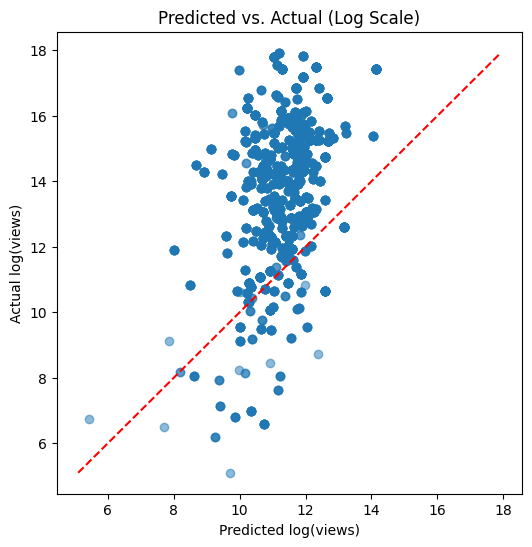

In [28]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val_pred, y_val_cv, alpha=0.5)
plt.plot([y_val_cv.min(), y_val_cv.max()],
         [y_val_cv.min(), y_val_cv.max()],
         'r--')
plt.xlabel("Predicted log(views)")
plt.ylabel("Actual log(views)")
plt.title("Predicted vs. Actual (Log Scale)")
plt.show()


In [29]:
import numpy as np
y_mean = y_train.mean()
baseline_rmse = np.sqrt(np.mean((y_test - y_mean)**2))
print("Baseline RMSE:", baseline_rmse)
print("y_train std:", y_train.std())


Baseline RMSE: 2.7080510533588598
y_train std: 2.403238548879056


## Results

In [118]:
import numpy as np
import pandas as pd

# Grab the scaled block (n_samples × 86)
X_scaled = additional_data_scaled  

#Recover the real-unit values for all samples
means  = scaler.mean_    # shape (86,)
scales = scaler.scale_   # shape (86,)
X_orig = X_scaled * scales + means  # still (n_samples, 86)

# 3) Wrap in a DataFrame for easy lookup
df_orig = pd.DataFrame(
    X_orig,
    columns=additional_cols_final,
    index=df_clean.index
)

# 4Slice out the train vs. test rows
df_train_orig = df_orig.loc[train_idx]  
df_test_orig  = df_orig.loc[test_idx]  




In [119]:
print("X_train shape:", X_train.shape)
print("Length of train_idx:", len(train_idx))

print("X_test shape:", X_test.shape)
print("Length of test_idx:", len(test_idx))


X_train shape: (22542, 8061)
Length of train_idx: 22542
X_test shape: (5636, 8061)
Length of test_idx: 5636


 97%|=================== | 5495/5636 [00:35<00:00]       

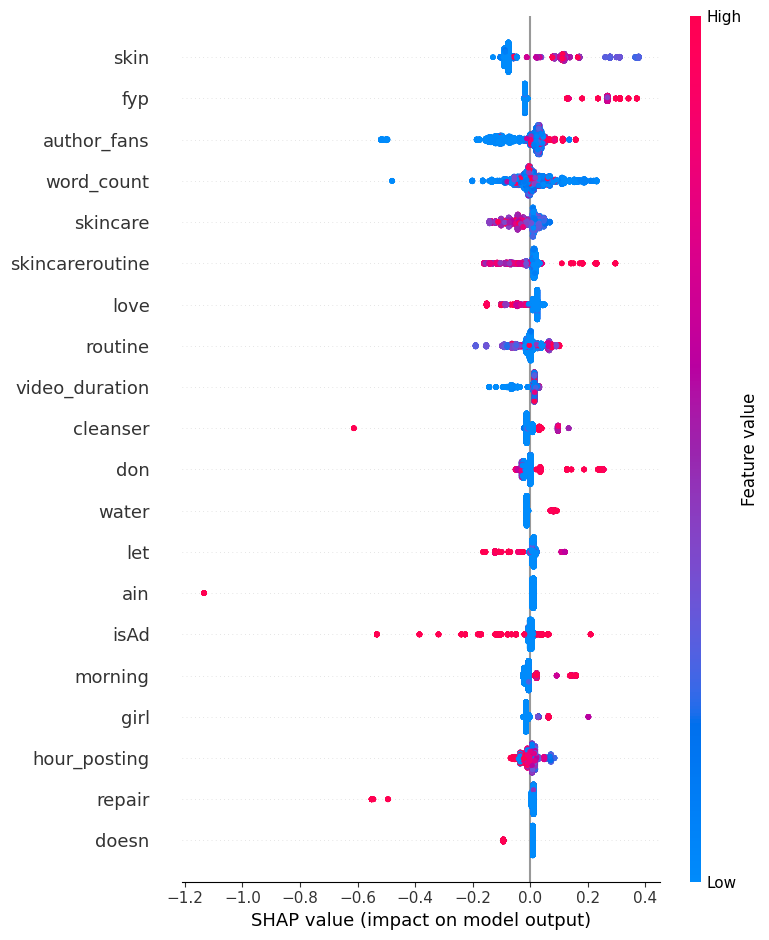

In [120]:
import shap

# Combine feature names
tfidf_feature_names = vectorizer.get_feature_names_out().tolist()
feature_names = tfidf_feature_names + additional_cols_final


# Convert your sparse train/test matrices into DataFrames
X_train_df = pd.DataFrame(
    X_train.toarray(),
    columns=feature_names,
    index=train_idx
)

X_test_df = pd.DataFrame(
    X_test.toarray(),
    columns=feature_names,
    index=test_idx
)

# SHAP explainer
explainer = shap.TreeExplainer(xgb_cv, X_train_df)  # your trained XGBoost model
shap_values = explainer.shap_values(X_test_df)

shap.summary_plot(shap_values, X_test_df, feature_names=feature_names)

 99%|===================| 5569/5636 [00:34<00:00]        

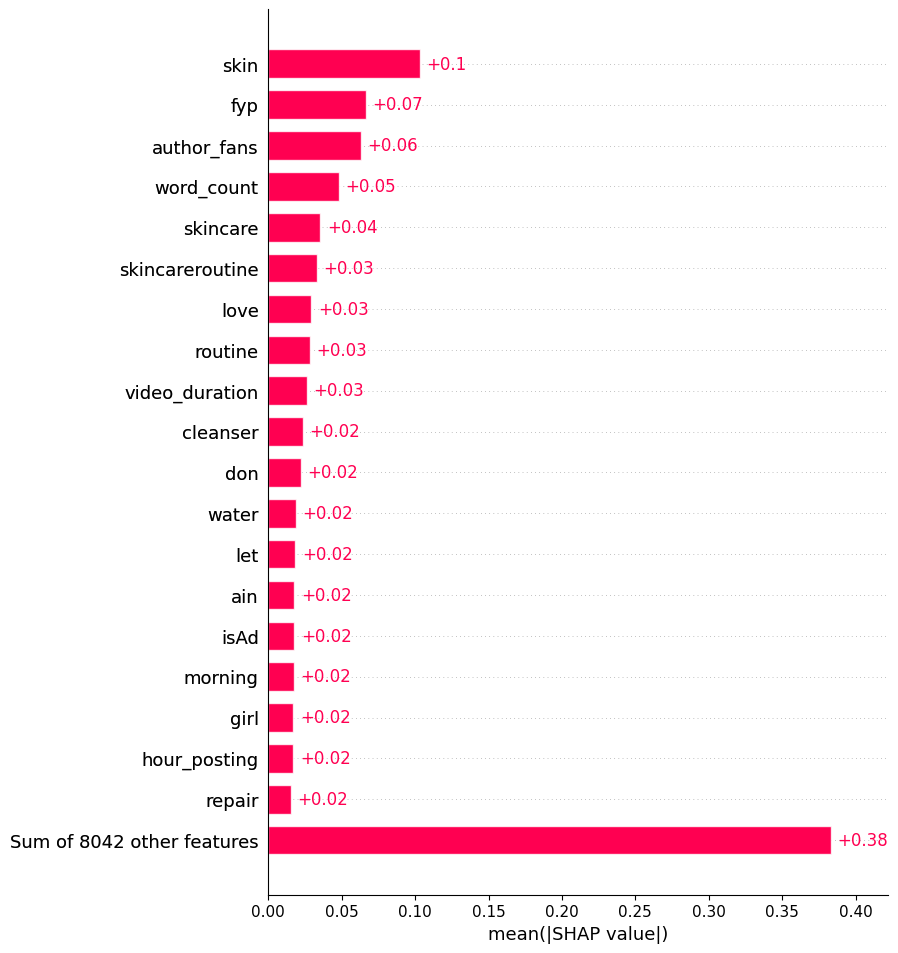

In [121]:
# mean absolute SHAP value per feature
shap_values = explainer(X_test_df)
shap.plots.bar(shap_values, max_display=20)

In [122]:
import numpy as np
import pandas as pd

# 1. build the full importance DataFrame
df_imp = (
    pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": np.abs(shap_values.values).mean(axis=0)
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

# 2. filter by threshold (10% of max)
thresh    = 0.1 * df_imp["mean_abs_shap"].max()
relevant  = df_imp[df_imp["mean_abs_shap"] >= thresh]

relevant_features = pd.DataFrame(relevant)
relevant_features

,feature,mean_abs_shap
0,skin,0.103165
1,fyp,0.066261
2,author_fans,0.062869
3,word_count,0.048043
4,skincare,0.035347
5,skincareroutine,0.033052
6,love,0.029166
7,routine,0.028298
8,video_duration,0.026337
9,cleanser,0.023356


### Now lets look into the actual distribution, how the Shap values changes for each value

In [123]:
explainer = shap.Explainer(xgb_cv, X_train_df)
shap_values = explainer(X_test_df)  

100%|===================| 5623/5636 [00:35<00:00]        

/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_30658/1657255722.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_plot.groupby("bin").agg(


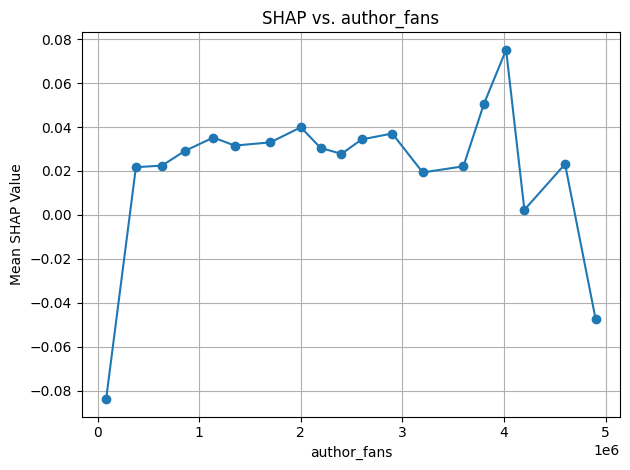

/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_30658/1657255722.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_plot.groupby("bin").agg(


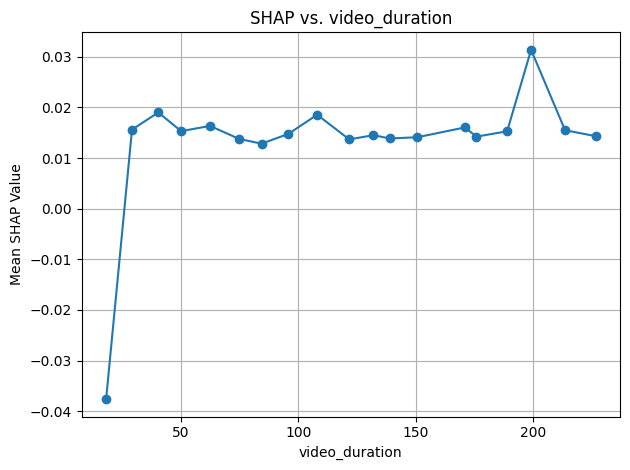

/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_30658/1657255722.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_plot.groupby("bin").agg(


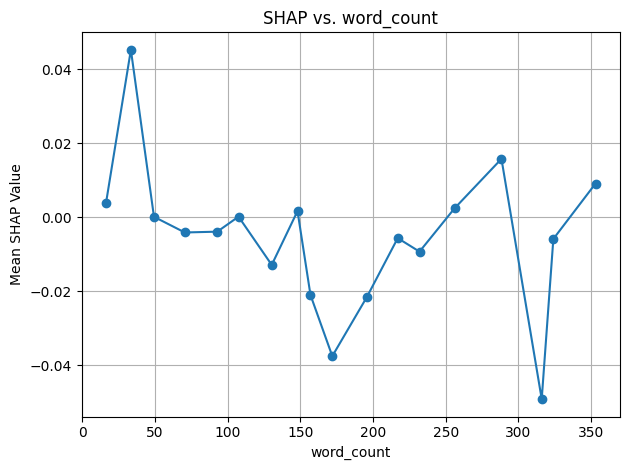

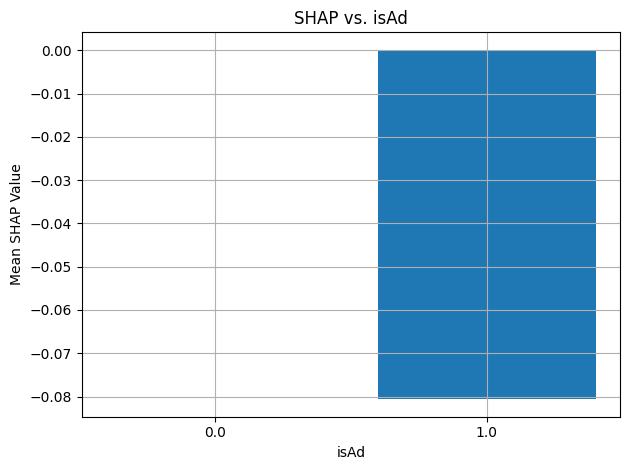

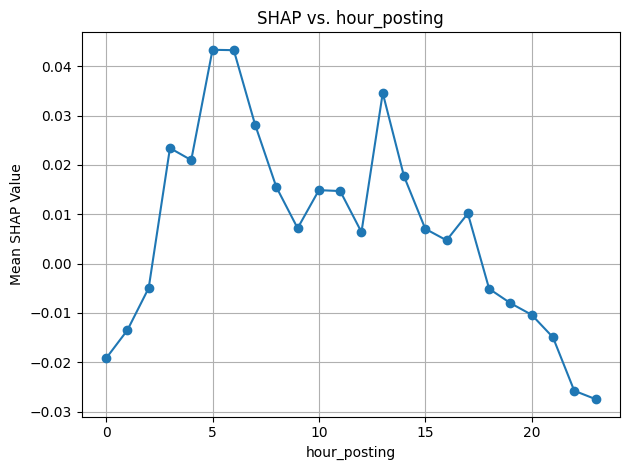

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

top_features = ["author_fans", "video_duration", "word_count", "isAd", "hour_posting"]

for feature in top_features:
    #values = df_test_orig.loc[test_idx, feature].reset_index(drop=True)
    values = df_test_orig[feature].reset_index(drop=True)
    shap_vals = shap_values[:, feature].values.ravel()
    df_plot = pd.DataFrame({feature: values, "shap_value": shap_vals})

    # 1. Binary feature
    if set(df_plot[feature].dropna().unique()) <= {0, 1}:
        summary = df_plot.groupby(feature)["shap_value"].mean().reset_index()
        summary.rename(columns={"shap_value": "mean_shap_value"}, inplace=True)

        plt.figure()
        plt.bar(summary[feature].astype(str), summary["mean_shap_value"])

    # 2. Discrete feature like 'hour'
    elif feature == "hour_posting":
        summary = df_plot.groupby(feature)["shap_value"].mean().reset_index()
        summary.rename(columns={"shap_value": "mean_shap_value"}, inplace=True)

        plt.figure()
        plt.plot(summary[feature], summary["mean_shap_value"], marker="o")

    # 3. Continuous feature
    else:
        p5, p95 = np.percentile(values, [5, 95])
        df_plot = df_plot[(values >= p5) & (values <= p95)]

        bins = np.linspace(df_plot[feature].min(), df_plot[feature].max(), 20)
        df_plot["bin"] = pd.cut(df_plot[feature], bins=bins, include_lowest=True)

        summary = df_plot.groupby("bin").agg(
            mean_shap_value=("shap_value", "mean"),
            bin_center=(feature, "mean")
        ).dropna().reset_index()

        plt.figure()
        plt.plot(summary["bin_center"], summary["mean_shap_value"], marker="o")

    # Save and show
    summary.to_csv(f"shap_vs_{feature}.csv", index=False)
    plt.xlabel(feature)
    plt.ylabel("Mean SHAP Value")
    plt.title(f"SHAP vs. {feature}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [125]:
print(xgb_cv.__class__)               # Should be XGBRegressor
print(xgb_cv.n_outputs_ if hasattr(xgb_cv, 'n_outputs_') else "unknown")
print(shap_values.values.shape)      # Check for (731,) vs (731, 2)


<class 'xgboost.sklearn.XGBClassifier'>
unknown
(5636, 8061)


/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_30658/1082200755.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby("bin")["shap_value"].mean()
/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_30658/1082200755.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_plot.groupby("bin")[feature].mean()


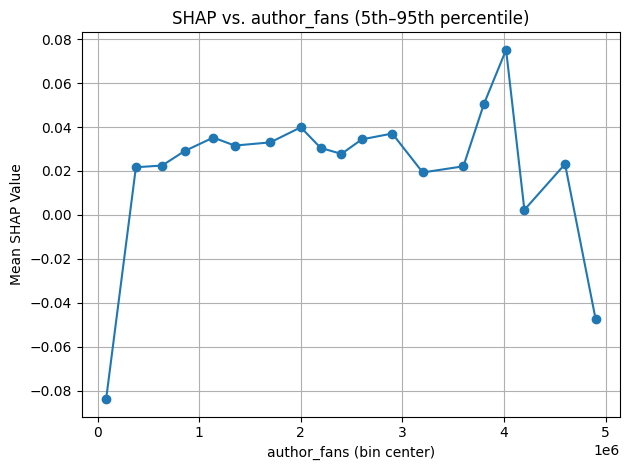

/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_30658/1082200755.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby("bin")["shap_value"].mean()
/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_30658/1082200755.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_plot.groupby("bin")[feature].mean()


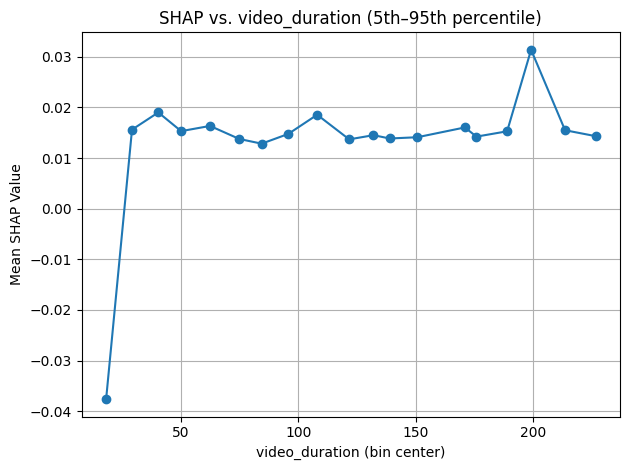

/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_30658/1082200755.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby("bin")["shap_value"].mean()
/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_30658/1082200755.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_plot.groupby("bin")[feature].mean()


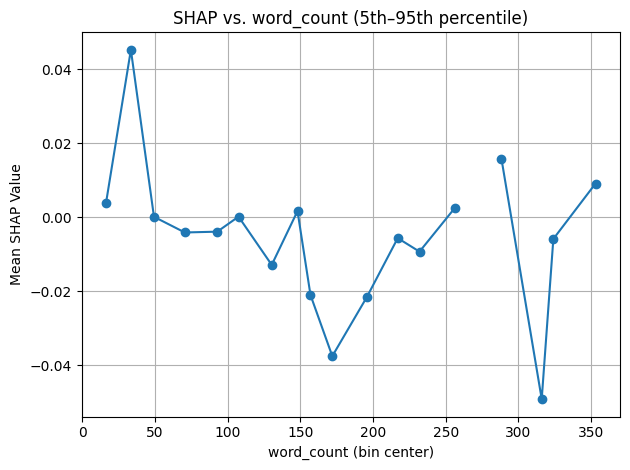

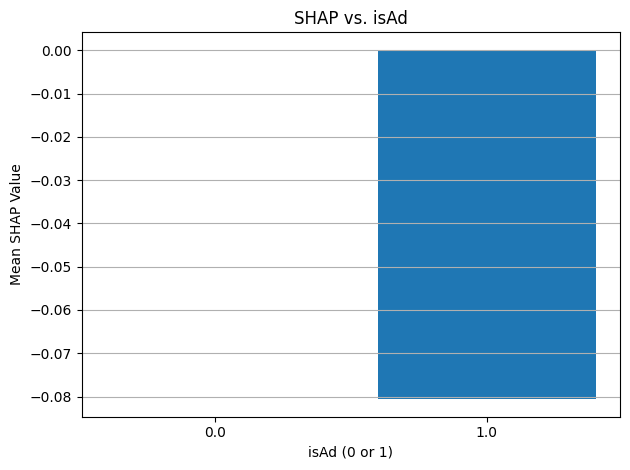

/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_30658/1082200755.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby("bin")["shap_value"].mean()
/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_30658/1082200755.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_plot.groupby("bin")[feature].mean()


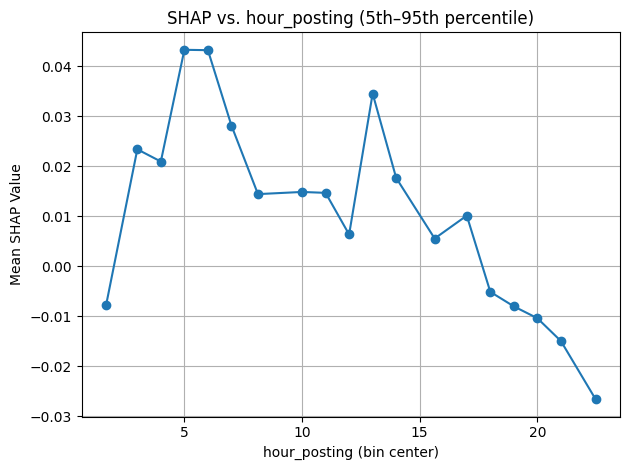

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

top_features = ["author_fans", "video_duration", "word_count", "isAd",'hour_posting']

for feature in top_features:
    # Get raw feature values from test set aligned with SHAP values
    feature_values = df_test_orig.loc[test_idx, feature].reset_index(drop=True)
    shap_val = shap_values[:, feature].values

    if feature == "isAd":
        # Binary feature → group by 0/1
        df_plot = pd.DataFrame({
            feature: feature_values,
            "shap_value": shap_val
        })

        group_means = df_plot.groupby(feature)["shap_value"].mean()
        output_df = group_means.reset_index().rename(columns={"shap_value": "mean_shap_value"})
        output_df.to_csv(f"shap_vs_{feature}.csv", index=False)

        # Bar plot
        plt.figure()
        plt.bar(output_df[feature].astype(str), output_df["mean_shap_value"])
        plt.xlabel(f"{feature} (0 or 1)")
        plt.ylabel("Mean SHAP Value")
        plt.title(f"SHAP vs. {feature}")
        plt.grid(True, axis="y")
        plt.tight_layout()
        plt.show()

    else:
        # Continuous feature → bin, filter, and plot
        p5, p95 = np.percentile(feature_values, [5, 95])
        mask = (feature_values >= p5) & (feature_values <= p95)

        filtered_vals = feature_values[mask]
        filtered_shap = shap_val[mask]

        df_plot = pd.DataFrame({
            feature: filtered_vals,
            "shap_value": filtered_shap
        })

        bin_edges = np.linspace(filtered_vals.min(), filtered_vals.max(), 20)
        df_plot["bin"] = pd.cut(df_plot[feature], bins=bin_edges, include_lowest=True)

        bin_means = df_plot.groupby("bin")["shap_value"].mean()
        bin_centers = df_plot.groupby("bin")[feature].mean()

        output_df = pd.DataFrame({
            f"{feature}_bin_center": bin_centers,
            "mean_shap_value": bin_means
        }).reset_index(drop=True)

        output_df.to_csv(f"shap_vs_{feature}.csv", index=False)

        plt.figure()
        plt.plot(output_df[f"{feature}_bin_center"], output_df["mean_shap_value"], marker="o")
        plt.xlabel(f"{feature} (bin center)")
        plt.ylabel("Mean SHAP Value")
        plt.title(f"SHAP vs. {feature} (5th–95th percentile)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Text(0.5, 1.0, 'Success Rate by Weekday')

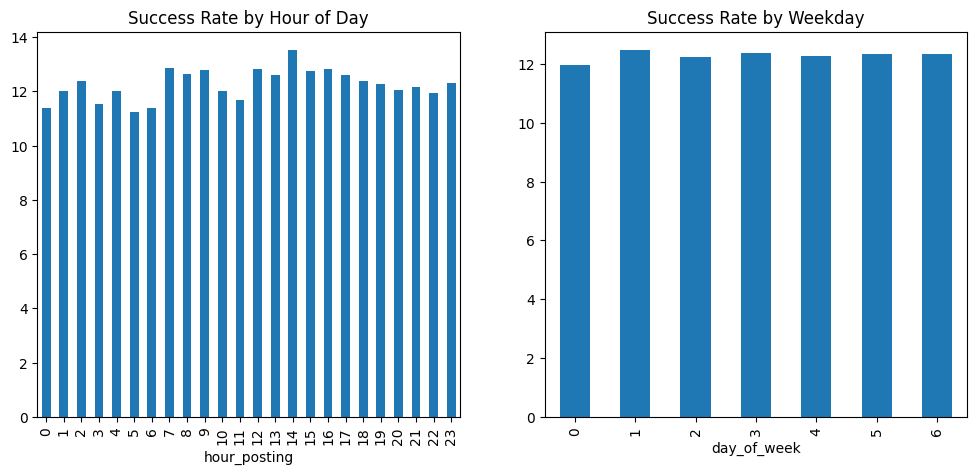

In [127]:
# Analyze success rate by hour
hourly_success = df.groupby('hour_posting')['viral_score'].mean()

# Analyze success rate by weekday
weekday_success = df.groupby('day_of_week')['viral_score'].mean()

# Visualize patterns
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
hourly_success.plot(kind='bar')
plt.title('Success Rate by Hour of Day')

plt.subplot(1,2,2)
weekday_success.plot(kind='bar')
plt.title('Success Rate by Weekday')


In [128]:
# Get feature names from TF-IDF vectorizer
tfidf_feature_names = vectorizer.get_feature_names_out()

# Find most important text features
text_feature_importances = pd.Series(
    xgb_cv.feature_importances_[:len(tfidf_feature_names)],
    index=tfidf_feature_names
).sort_values(ascending=False)[:20]
text_feature_importances

step                              0.014739
face like                         0.014705
like day                          0.014658
skincare routine                  0.014448
dark                              0.010809
chin                              0.010026
forehead                          0.009798
think                             0.009342
cut                               0.008834
watch                             0.008702
gon                               0.008682
grwmroutine                       0.008295
drive                             0.008001
bump                              0.007535
grwmaesthetic skincare            0.007172
skincareroutine koreanskincare    0.006996
assim                             0.006853
peptide                           0.006826
cream feel                        0.006595
selfcare                          0.006584
dtype: float32

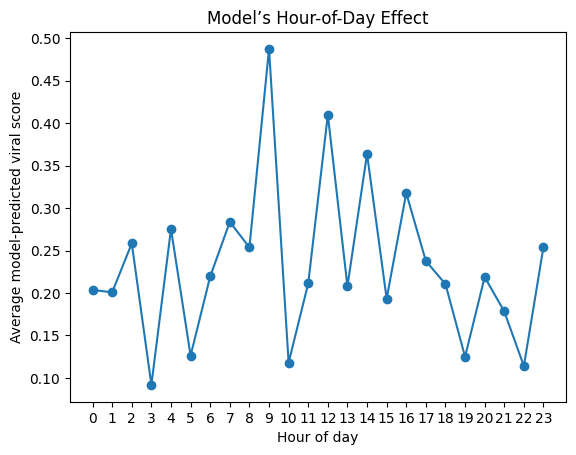

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Predict on your cleaned data
y_pred = xgb_cv.predict(X_combined)   # or X_test if you want just test set
hours  = df_clean['hour_posting']          # same index as X_combined

# 2. Build DataFrame of hour vs. prediction
df_pred = pd.DataFrame({'hour_posting': hours, 'pred': y_pred})

# 3. Compute mean predicted viral_score by hour
hour_mean = df_pred.groupby('hour_posting')['pred'].mean().sort_index()

# 4. Plot
plt.plot(hour_mean.index, hour_mean.values, marker='o')
plt.xlabel('Hour of day')
plt.ylabel('Average model-predicted viral score')
plt.title('Model’s Hour-of-Day Effect')
plt.xticks(range(0,24))
plt.show()


### Train with is_viral

In [130]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
import numpy as np

# Ensure data sorted by time
y = df['is_viral'].reset_index(drop=True)

tscv = TimeSeriesSplit(n_splits=5)

accuracy_scores = []
f1_scores = []
auc_scores = []

for train_idx, val_idx in tscv.split(X_combined):
    X_train_cv, X_val_cv = X_combined[train_idx], X_combined[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    xgb_cv = XGBClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=1,
        tree_method='hist',
        eval_metric='logloss',
        scale_pos_weight=3.0
    )

    xgb_cv.fit(X_train_cv, y_train_cv)
    y_val_pred = xgb_cv.predict(X_val_cv)
    y_val_proba = xgb_cv.predict_proba(X_val_cv)[:, 1]

    accuracy_scores.append(accuracy_score(y_val_cv, y_val_pred))
    f1_scores.append(f1_score(y_val_cv, y_val_pred))
    auc_scores.append(roc_auc_score(y_val_cv, y_val_proba))

print("Temporal CV Accuracy (mean):", np.mean(accuracy_scores))
print("Temporal CV F1 (mean):", np.mean(f1_scores))
print("Temporal CV AUC (mean):", np.mean(auc_scores))


Temporal CV Accuracy (mean): 0.7570698466780239
Temporal CV F1 (mean): 0.2341340258774383
Temporal CV AUC (mean): 0.6920942885002267


In [131]:
# Assuming y is binary (0 or 1)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Split chronologically (sorted by time)
n_total = X_combined.shape[0]
split_point = int(n_total * 0.8)
train_idx = np.arange(0, split_point)
test_idx = np.arange(split_point, n_total)

X_train = X_combined[train_idx]
X_test = X_combined[test_idx]
y_train = df['is_viral'].iloc[train_idx].astype(int)
y_test = df['is_viral'].iloc[test_idx].astype(int)

# Train final model
final_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    scale_pos_weight=2.7
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)


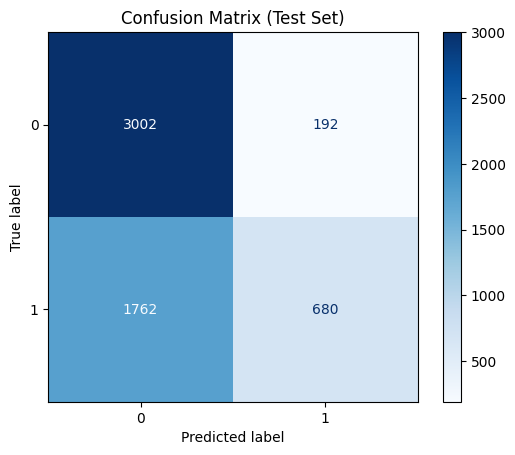

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [133]:
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)
top_features = mean_abs_shap.head(30).index.tolist()  # or any top-N
X_train_top = X_train_df[top_features]
X_test_top  = X_test_df[top_features]


In [89]:
top_features

['skin',
 'fyp',
 'author_fans',
 'word_count',
 'skincare',
 'skincareroutine',
 'love',
 'routine',
 'video_duration',
 'cleanser',
 'don',
 'water',
 'let',
 'ain',
 'isAd',
 'morning',
 'girl',
 'hour_posting',
 'repair',
 'doesn',
 'skincare routine',
 'hashtag_skincare',
 'mask',
 'fyp skincare',
 'cleanse',
 'comment',
 'glowyskin',
 'girlie',
 'nice',
 'day']

In [134]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3.0,  # adjust for imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train_top, y_train)

/Users/ritushetkar/env_capstone/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [135]:
from sklearn.metrics import classification_report

# Predict class probabilities
y_proba = xgb.predict_proba(X_test_top)[:, 1]

# Choose a threshold (e.g. 0.4 based on F1 curve)
threshold = 0.4
y_pred = (y_proba > threshold).astype(int)

# Print report
print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

           0      0.642     0.844     0.729      3194
           1      0.654     0.386     0.485      2442

    accuracy                          0.645      5636
   macro avg      0.648     0.615     0.607      5636
weighted avg      0.647     0.645     0.624      5636



In [136]:
import numpy as np
import pandas as pd

# 1) Inverse transform the scaled data
X_scaled = additional_data_scaled
means  = scaler.mean_
scales = scaler.scale_
X_orig = X_scaled * scales + means

# 2) Wrap in DataFrame
df_orig = pd.DataFrame(
    X_orig,
    columns=additional_cols_final,
    index=df_clean.index
)

# 3) Slice out rows matching train/test split and SHAP inputs
df_train_orig = df_orig.loc[X_train_top.index].reset_index(drop=True)
df_test_orig  = df_orig.loc[X_test_top.index].reset_index(drop=True)

 95%|=================== | 5350/5636 [00:11<00:00]       

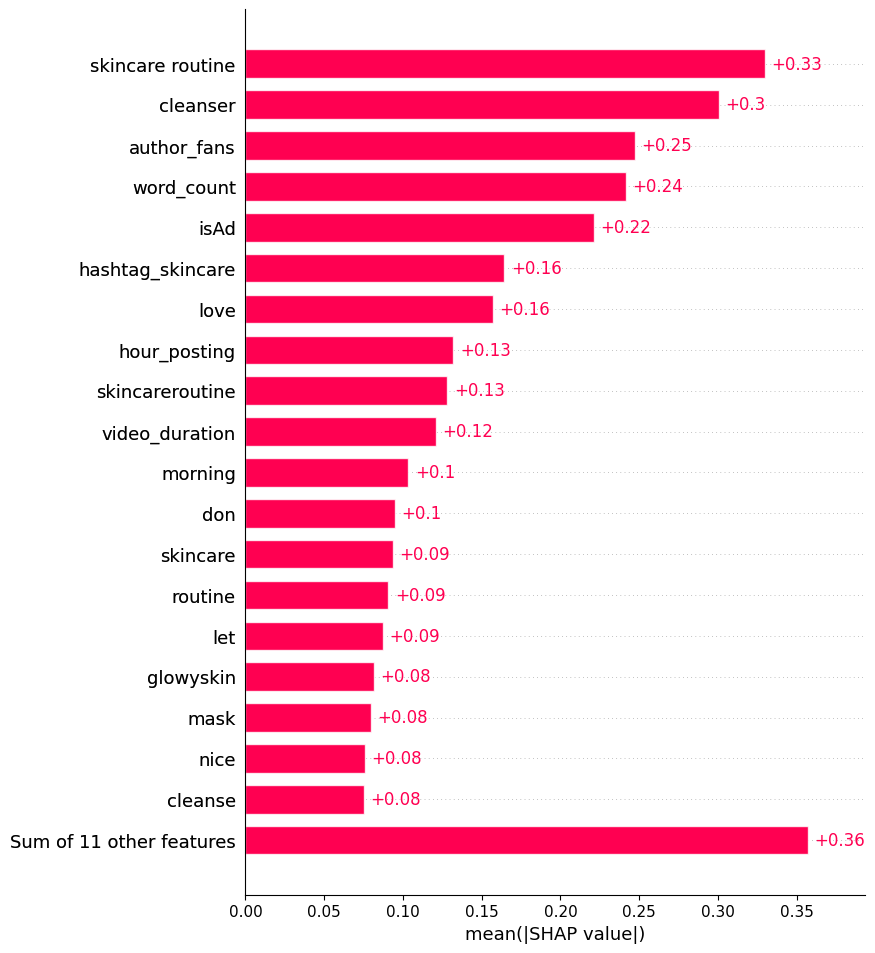

In [91]:
import shap

explainer = shap.Explainer(xgb, X_train_top)
shap_values = explainer(X_test_top)

shap.plots.bar(shap_values, max_display=20)  # Global importance


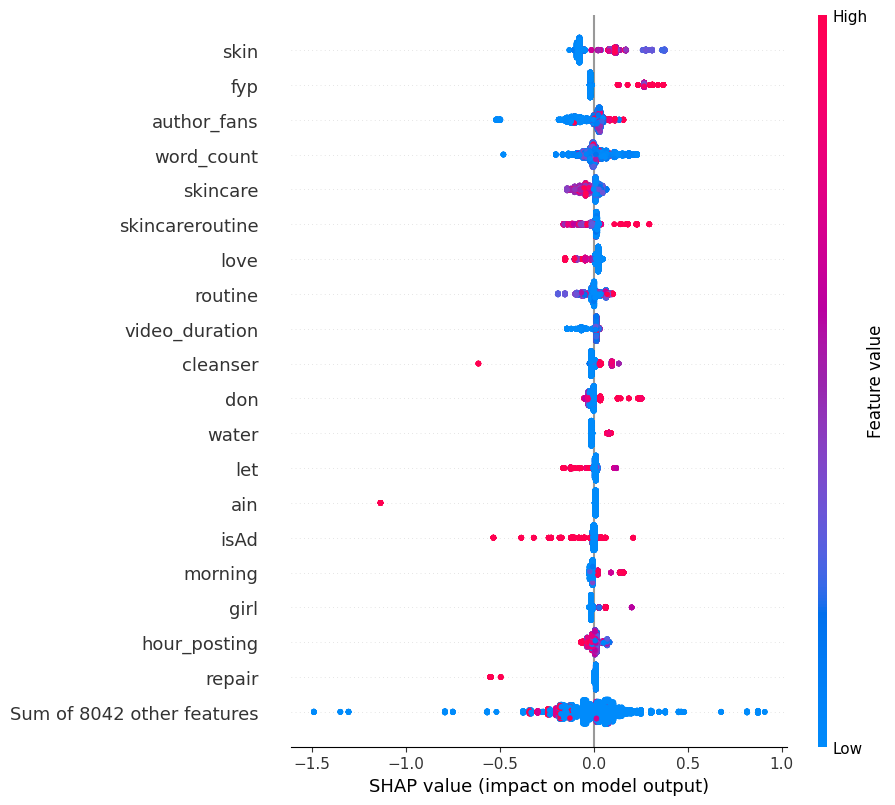

In [137]:
shap.plots.beeswarm(shap_values, max_display=20)  # Dots colored by feature value


In [141]:
top_features = ["author_fans", "video_duration", "word_count", "isAd", "hour_posting"]


In [138]:
relevant_features

,feature,mean_abs_shap
0,skin,0.103165
1,fyp,0.066261
2,author_fans,0.062869
3,word_count,0.048043
4,skincare,0.035347
5,skincareroutine,0.033052
6,love,0.029166
7,routine,0.028298
8,video_duration,0.026337
9,cleanser,0.023356


In [142]:
relevant_features_filtered = relevant_features[relevant_features["feature"].isin(top_features)].reset_index(drop=True)


In [143]:
relevant_features_filtered

,feature,mean_abs_shap
0,author_fans,0.062869
1,word_count,0.048043
2,video_duration,0.026337
3,isAd,0.017582
4,hour_posting,0.016927


In [144]:


# Prepare list to store ranges
optimal_ranges = []
mean_shap_vals = []

for feat in top_features:
    df_feat = pd.DataFrame({
        "feature_val": df_test_orig[feat].values,
        "shap_val": shap_values[:, feat].values
    })

    # Remove outliers
    p1, p99 = np.percentile(df_feat["feature_val"], [1, 99])
    df_feat = df_feat[(df_feat["feature_val"] >= p1) & (df_feat["feature_val"] <= p99)]

    bins = pd.cut(df_feat["feature_val"], bins=100)
    summary = df_feat.groupby(bins, observed=False)["shap_val"].mean()

    # Get bin with max SHAP value
    if not summary.empty:
        best_bin = summary.idxmax()
        best_range = f"{best_bin.left:.1f}–{best_bin.right:.1f}"
    else:
        best_range = "n/a"

    optimal_ranges.append(best_range)
    mean_abs_shap = np.abs(shap_values.values[:, X_test_df.columns.get_loc(feat)]).mean()
    mean_shap_vals.append(mean_abs_shap)

relevant_features_filtered = pd.DataFrame({
    "feature": top_features,
    "mean_abs_shap": mean_shap_vals,
    "optimal_value_range": optimal_ranges
})
# Add as new column
relevant_features_filtered["optimal_value_range"] = optimal_ranges

relevant_features_filtered.to_csv("successful_post_range_nb.csv")

# Old

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor


# drop all unwanted cols
X = df.drop([
    'post_id',
    'is_viral',
    'diggCount',
    'shareCount',
    'playCount',
    'collectCount',
    'commentCount',
    'engagement',
    'searchHashtag_name',
    'searchHashtag_views',
    'author_nickName',
    'detected_language',
    'textLanguage',
    'date',
    'createTimeISO',
    'author_signature',
    'location_address',
    'transcribed_text',
    'video_description',
    'hashtag_text',
    'text_all',
    'success_score',
    'viral_score',
], axis=1)

y = df['viral_score']

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=10000, ngram_range=(1,3)), 'text'),
        ('num', StandardScaler(),      ['author_fans','video_duration']),
        ('bin', 'passthrough',         ['isAd','isSponsored']),
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('reg', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        random_state=42
    ))
])

# CV
cv_mae = -cross_val_score(
    pipeline, X_train, y_train,
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
).mean()
print(f"CV MAE: {cv_mae:.3f}")

In [ ]:
# final fit with early stopping
pipeline.fit(
    X_train, y_train,
)

# test MAE
print("Test MAE:", mean_absolute_error(y_test, pipeline.predict(X_test)))

In [ ]:
print("feature_names_in_:", preprocessor.feature_names_in_)


In [ ]:
feature_names = preprocessor.get_feature_names_out()

In [ ]:
# grab fitted ColumnTransformer
pre = pipeline.named_steps['pre']

# this array is exactly what the transformer saw when fitting
in_feats = pre.feature_names_in_

# now request the output names
feat_names = pre.get_feature_names_out(input_features=in_feats)


In [ ]:
input_feats = np.array(X_train.columns, dtype=pre.feature_names_in_.dtype)
assert np.array_equal(input_feats, pre.feature_names_in_)
feat_names = pre.get_feature_names_out(input_features=input_feats)


In [ ]:
import shap
pre = pipeline.named_steps['pre']
feat_names = pre.get_feature_names_out()

# explainer
explainer = shap.Explainer(pipeline.named_steps['reg'], pipeline.named_steps['pre'].transform(X_train))
shap_values = explainer(pipeline.named_steps['pre'].transform(X_test))

# summary plot: shows feature impact direction
shap.summary_plot(shap_values, pipeline.named_steps['pre'].transform(X_test), feat_names)


In [ ]:
# 2 — feature names after all preprocessing
feat_names = pipeline.named_steps['pre'].get_feature_names_out()


imp = pipeline.named_steps['reg'].feature_importances_

# 4 — rank
order = np.argsort(imp)          # ascending
top_neg = [(feat_names[i], imp[i]) for i in order[:20]]          # worst
top_pos = [(feat_names[i], imp[i]) for i in order[-20:][::-1]]   # best

print("↑ success:", top_pos)
print("↓ success:", top_neg)


In [ ]:
import numpy as np
import pandas as pd

# 1. Grab the fitted preprocessor and regressor
pre = pipeline.named_steps['pre']
reg = pipeline.named_steps['reg']

# 2. Build the full feature‐name list in the same order the model sees them
#   a) text features
text_feats = pre.named_transformers_['text'].get_feature_names_out()
#   b) numeric + binary features (in the order you passed them)
num_feats = ['author_fans', 'video_duration']
bin_feats = ['isAd', 'isSponsored']
feature_names = np.concatenate([text_feats, num_feats, bin_feats])

# 3. Pair names with importances & sort
importances = reg.feature_importances_
feat_imp = pd.Series(importances, index=feature_names)
feat_imp = feat_imp.sort_values(ascending=False)

# 4. Show top 10
print(feat_imp.head(40))


In [ ]:
# after model.fit(...)
names = model.named_steps['pre'].get_feature_names_out()
imp   = model.named_steps['clf'].feature_importances_

# sort ascending ⇒ smallest gains first
irrelevant = (
    pd.Series(imp, index=names)
      .sort_values(ascending=True)
)

# show bottom 30 (near-zero = basically unused)
print(irrelevant.head(30))

In [ ]:

# 2 — isolate pieces
prep  = pipeline.named_steps['pre']
clf   = pipeline.named_steps['clf']
names = prep.get_feature_names_out()



# 4 — build explainer (LinearExplainer fits logistic/linear models)
expl = shap.LinearExplainer(clf, X_tr, feature_names=names)

# 5 — global view
shap_values = expl(X_va)              # SHAP for validation rows
shap.summary_plot(shap_values, X_va, feature_names=names, max_display=25)

# 6 — single-post waterfall
idx = 0                                # any row index
shap.waterfall_plot(shap_values[idx], max_display=20)
